In [1]:
import sys
sys.path.append("c:/users/david/desktop/sandbox")
import pandas as pd
import numpy as np
from pyrecs.train import lightfm_wrapper

%load_ext autoreload
%autoreload 2

C:\Users\David\Desktop\Sandbox\pyrecs\env\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Pure CF

In [2]:
ratings = pd.read_csv('../data/movielens-1m/ratings.dat', delimiter='::', 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                      engine='python').sort_values(by='timestamp')
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['user_id'] = ratings['user_id'].astype(str)
ratings['movie_id'] = ratings['movie_id'].astype(str)

print(ratings['timestamp'].describe(datetime_is_numeric=True))
print(ratings.shape)
ratings.head()

count                          1000209
mean     2000-10-22 19:41:35.404665344
min                2000-04-25 23:05:32
25%                2000-08-03 11:37:17
50%                2000-10-31 18:46:46
75%                2000-11-26 06:42:19
max                2003-02-28 17:49:50
Name: timestamp, dtype: object
(1000209, 4)


,user_id,movie_id,rating,timestamp
1000138,6040,858,4,2000-04-25 23:05:32
1000153,6040,2384,4,2000-04-25 23:05:54
999873,6040,593,5,2000-04-25 23:05:54
1000007,6040,1961,4,2000-04-25 23:06:17
1000192,6040,2019,5,2000-04-25 23:06:17


In [3]:
train_df = ratings.iloc[:900000].copy()
test_df = ratings.iloc[900000:].copy()

train_df.shape, test_df.shape

((900000, 4), (100209, 4))

In [4]:
train_df['user_id'].nunique(), test_df['user_id'].nunique(), len(set(train_df['user_id'].unique()) & set(test_df['user_id'].unique()))

(6010, 1209, 1179)

In [5]:
train_df['movie_id'].nunique(), test_df['movie_id'].nunique(), len(set(train_df['movie_id'].unique()) & set(test_df['movie_id'].unique()))

(3678, 3407, 3379)

In [11]:
model_kwargs = {
    'no_components':32,
    'learning_rate':0.05,
    'loss':'warp',
    'random_state':42
}
train_kwargs = {
    'num_epochs':2,
    'num_threads':1,
    'eval_epochs':'all',
    'plot':True
}
lfm = lightfm_wrapper.LightFM(users_col='user_id', items_col='movie_id', interactions_type='ones',
                              model_kwargs=model_kwargs, train_kwargs=train_kwargs,
                              n_recs=10, tfrs_prediction_batch_size=5000, fill_most_popular=True)

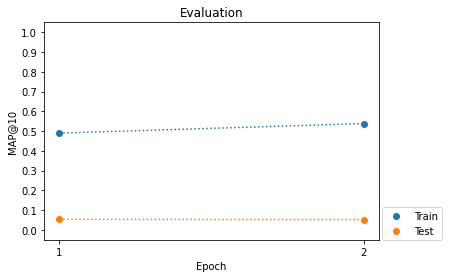

Training: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [01:43<00:00, 51.65s/it]


In [12]:
lfm.run(train_df=train_df, test_df=test_df)

In [13]:
lfm.train_evaluations, lfm.test_evaluations

([0.4897323351229935, 0.5379389249629721],
 [0.053400143763047, 0.05209772266287884])

# Hybrid CF

In [21]:
users = pd.read_csv('../data/movielens-1m/users.dat', delimiter='::',
                    header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip'], 
                    engine='python')
users['user_id'] = users['user_id'].astype(str)
users['user_id_copy'] = users['user_id'].copy()
users['occupation'] = users['occupation'].astype(str)
print(users.shape)
display(users.head())


movies = pd.read_csv('../data/movielens-1m/movies.dat', delimiter='::',
                     header=None, names=['movie_id', 'title', 'genres'], 
                     engine='python', encoding="ISO-8859-1")
movies['movie_id'] = movies['movie_id'].astype(str)
movies['movie_id_copy'] = movies['movie_id'].copy()
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

def extract_year(x):
    try:
        return int(x.split('(')[-1].rstrip(')'))
    except:
        return 0
movies['year'] = movies['title'].apply(extract_year)

print(movies.shape)
display(movies.head())

(6040, 6)


,user_id,gender,age,occupation,zip,user_id_copy
0,1,F,1,10,48067,1
1,2,M,56,16,70072,2
2,3,M,25,15,55117,3
3,4,M,45,7,02460,4
4,5,M,25,20,55455,5


(3883, 5)


,movie_id,title,genres,movie_id_copy,year
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1,1995
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",2,1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3,1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",4,1995
4,5,Father of the Bride Part II (1995),[Comedy],5,1995


In [22]:
cols = ['user_id','user_id_copy','gender','age','occupation']
train_user_features_dict = users[users['user_id'].isin(train_df['user_id'].unique())][cols].set_index('user_id').to_dict(orient='index')
test_user_features_dict = users[users['user_id'].isin(test_df['user_id'].unique()) 
                                & ~users['user_id'].isin(train_df['user_id'].unique())][cols].set_index('user_id').to_dict(orient='index')

len(train_user_features_dict), len(test_user_features_dict)

(6010, 30)

In [23]:
cols = ['genres','year','movie_id_copy','movie_id']
train_item_features_dict = movies[movies['movie_id'].isin(train_df['movie_id'].unique())][cols].set_index('movie_id').to_dict(orient='index')
test_item_features_dict = movies[movies['movie_id'].isin(test_df['movie_id'].unique()) 
                                & ~movies['movie_id'].isin(train_df['movie_id'].unique())][cols].set_index('movie_id').to_dict(orient='index')

len(train_item_features_dict), len(test_item_features_dict)

(3678, 28)

In [30]:
model_kwargs = {
    'no_components':32,
    'learning_rate':0.05,
    'loss':'warp',
    'random_state':42
}
train_kwargs = {
    'num_epochs':2,
    'num_threads':1,
    'eval_epochs':'all',
    'plot':True
}
lfm = lightfm_wrapper.LightFM(users_col='user_id', items_col='movie_id', interactions_type='ones',
                              model_kwargs=model_kwargs, train_kwargs=train_kwargs,
                              n_recs=10, tfrs_prediction_batch_size=5000, fill_most_popular=True)

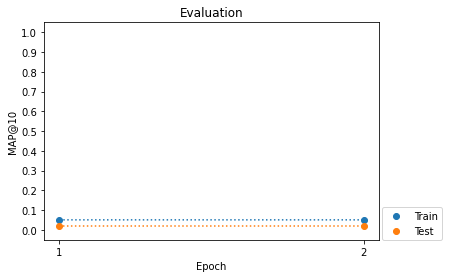

Training: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [02:26<00:00, 73.31s/it]


In [31]:
lfm.run(train_df=train_df, test_df=test_df,
        train_user_features_dict=train_user_features_dict, 
        train_item_features_dict=train_item_features_dict,
        test_user_features_dict=test_user_features_dict, 
        test_item_features_dict=test_item_features_dict)

In [32]:
lfm.train_evaluations, lfm.test_evaluations

([0.05093173414679238, 0.050930842775268735],
 [0.020418935073952996, 0.020418935073952996])